<a href="https://colab.research.google.com/github/alvinwalker314/DS-Unit-2-Classification-1/blob/master/DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
!pip install category_encoders

In [0]:
#Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [0]:
#Load Data
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [5]:
df.shape

(13958, 18)

In [0]:
#check null values and drop playername
df.isna().sum()
df.drop(columns= 'player_name', inplace=True)
#copy data
basketball= df.copy()

In [0]:
#engineer homecourt adv
basketball['homecourt_advantage']= basketball['htm'].isin(['GSW'])

In [0]:
#engineer seconds left period
basketball['seconds_left_period']= (basketball['minutes_remaining']*60) + basketball['seconds_remaining']

In [0]:
#engineer seconds left game
basketball['seconds_left_game']= (basketball['seconds_remaining'])+ (basketball['minutes_remaining']*60)+ (((4-basketball['period'])*12)*60)

In [0]:
#drop redundant columns
basketball.drop(columns= ['minutes_remaining', 'seconds_remaining', 'htm'], inplace=True)

In [0]:
#split data to train, validate, test
train= basketball['2009-10-28': '2017-06-12']
validate= basketball['2017-10-17': '2018-06-08']
test= basketball['2018-10-16' : '2019-06-05']

In [76]:
train.shape, validate.shape, test.shape

((11081, 18), (1168, 18), (1709, 18))

In [77]:
#grabbed my target and features
basketball_target= train['shot_made_flag']
train.drop(columns=['shot_made_flag'], inplace=True)
validation_target= validate['shot_made_flag']
validate.drop(columns=['shot_made_flag'], inplace=True)
test_target= test['shot_made_flag']
test.drop(columns=['shot_made_flag'], inplace=True)
basketball_features= train




/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
#split data into train and test
X_train, X_test, Y_train, Y_test= train_test_split(
basketball_features, basketball_target, train_size= 0.8, test_size= 0.2, stratify= basketball_target) 

In [67]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8864, 20), (2217, 20), (8864,), (2217,))

In [0]:
#encode data
encoder= ce.OrdinalEncoder()
X_train_encoded= encoder.fit_transform(X_train)
X_test_encoded= encoder.transform(X_test)
validate_encoded= encoder.transform(validate)
test_encoded= encoder.transform(test)

In [0]:
#create baseline for test data
X_test_encoded['baseline']= 1
baseline= X_test_encoded['baseline']

In [81]:
#print baseline accuracy for test data
print('test baseline: '+str(accuracy_score(baseline, Y_test)))

test baseline: 0.4727108705457826


In [0]:
#drop baseline
X_test_encoded.drop(columns= 'baseline', inplace=True)

In [83]:
#create a random forest with 100 trees, fit to validation data and scored validation data
forest= RandomForestClassifier(n_estimators= 100, random_state= 42)
forest.fit(X_train_encoded, Y_train)
print('Training test score: '+ str(forest.score(X_test_encoded, Y_test)))

Training test score: 0.6341903473161931


In [84]:
print('Validation score: '+ str(forest.score(validate_encoded, validation_target)))

Validation score: 0.5941780821917808


In [85]:
#score test data with model 
print('Test Score: '+ str(forest.score(test_encoded, test_target)))

Test Score: 0.6284376828554711


In [0]:
#grabbed importances of model
importances= pd.Series(forest.feature_importances_, X_train.columns)

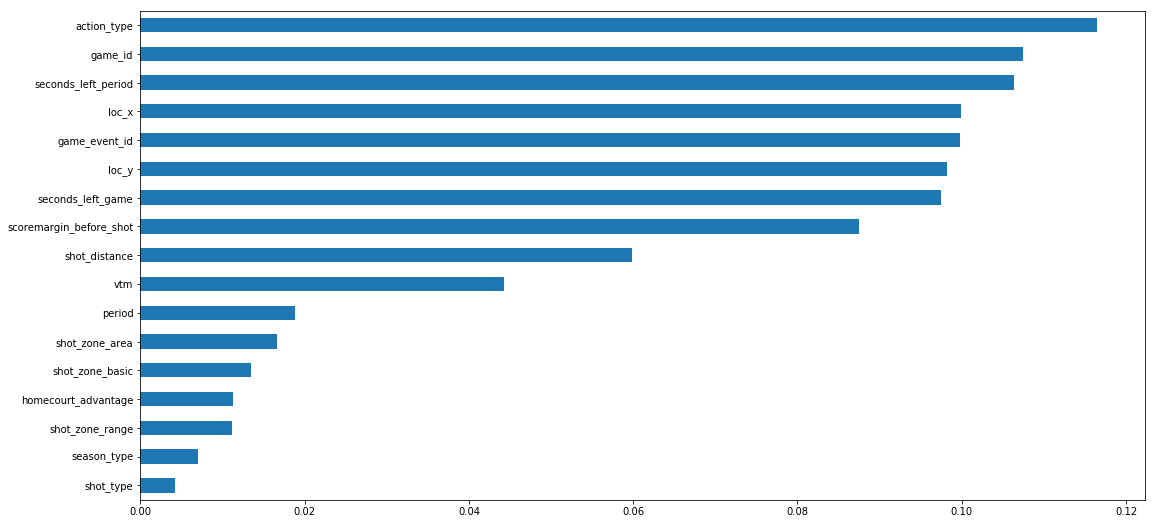

In [87]:
#plot importances
fig= plt.figure(figsize= (18,9))
importances.sort_values().plot.barh()

In [88]:
#total values
total= 85 + 58 + 8+ 36
#total correct predictions
correct_pred= 85 + 36
#total times predicted positive
pos_pred= 58 + 36
#total times correctly predicting positive
cor_pos= 36
#total correct
total_pos= 8 + 36

print('Accuracy: '+str(correct_pred/ total))
print('Precision: '+str(cor_pos/ pos_pred))
print('Recall: ' +str(cor_pos/ total_pos))

Accuracy: 0.6470588235294118
Precision: 0.3829787234042553
Recall: 0.8181818181818182
